### The objective

The 58th US presidential election was held on Tuesday, November 8, 2016. The Republican ticket, businessman Donald Trump and Indiana governor Mike Pence defeated the Democratic ticket of former secretary of state and First Lady of the United States Hillary Clinton and the junior senator from Virginia Tim Kaine, in what was considered one of the biggest political upsets in American history.

The goal of this analysis is to formulate a strategy for the Democrats that would lead them to victory in the upcoming 2020 election. First, we will identify which states could be considered as the 'swing states' - that is, the states on which they should focus the most during the campaign. Next, we will try to create a profile of an average Trump supporter based on the 2016 primary election data. Lastly, we will attempt to establish which 'swing states' populations don't really fit this profile. These voters could be the easiest to sway away from voting for Trump.

### 2016 election results

Firstly, we will plot the 2016 US presidential election results


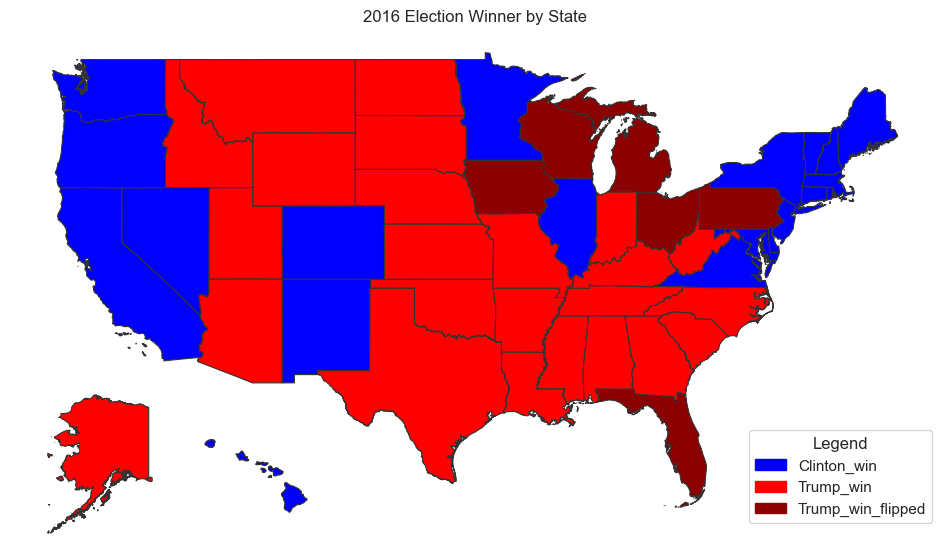

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib.patches import Patch


df = gpd.read_file('us_states/cb_2018_us_state_500k.shp')

# We get rid of all the territories that don't take part in the elections
df = df[~df['STATEFP'].isin(['60', '66', '69', '72', '78'])]
results = pd.read_csv('election_data.csv')
df = df.merge(results,left_on='STUSPS',right_on='state_abbreviation')



# We map the results
df['color'] = df['clinton_votes'] > df['trump_votes']
df['color'] = df['color'].map({True: 'blue', False: 'red'})
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.title('2016 Election Winner by State')
ax.axis('off')

flipped_states = ['12', '19', '26', '39', '42', '55']
df.loc[df['STATEFP'].isin(flipped_states),'color'] = 'darkred'

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = df[df.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color=alaska_gdf.color, linewidth=0.8,ax=akax, edgecolor='0.2', legend=True)

# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = df[df.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf.color, linewidth=0.8,ax=hiax, edgecolor='0.2', legend=True)

# add continental US
continental = df[~df['STATEFP'].isin(['02', '15'])]
continental.plot(color=continental['color'], linewidth=0.8, ax=ax, edgecolor='0.2', legend=True)

# Add the legend
legend_colors = ['blue', 'red', 'darkred']
labels = ['Clinton_win', 'Trump_win', 'Trump_win_flipped']
legend_patches = [
    Patch(color=color, label=label)
    for label, color in zip(labels, legend_colors)
]

ax.legend(handles=legend_patches, title='Legend', loc='lower right')


Trump managed to win the general election with 304 of the 538 electoral votes. He held every state that the republicans won in 2012 and flipped additional 6; Iowa, Wisconsin, Michigan, Ohio, Pennsylvania and Florida.

It is important to note though, that despite such a decisive outcome, Clinton actually won the popular vote. This suggests that there were quiet a few states where the result was very close. We will now try to identify these states.

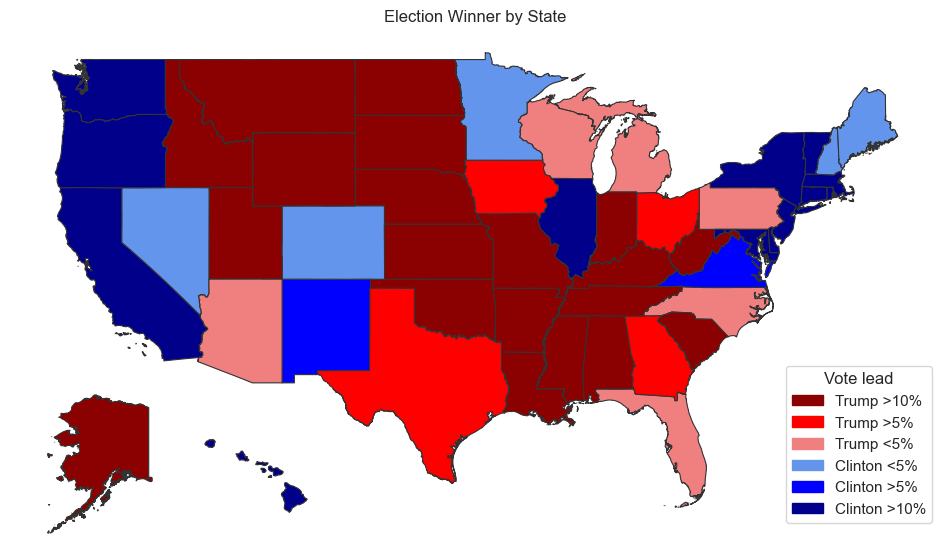

In [437]:
df['advantage'] = (df['clinton_votes'] - df['trump_votes']) / df['total_votes']
bins = [-1, -0.1, -0.05, 0, 0.05, 0.1, 1]
labels = ['Trump >10%', 'Trump >5%', 'Trump <5%', 'Clinton <5%', 'Clinton >5%', 'Clinton >10%']
df['result'] = pd.cut(df['advantage'], bins=bins, labels=labels, include_lowest=True)
df['shade'] = df['result'].map({'Trump >10%': 'darkred', 'Trump >5%': 'red', 'Trump <5%': 'lightcoral', 'Clinton <5%': 'cornflowerblue', 'Clinton >5%': 'blue', 'Clinton >10%': 'darkblue'})
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.title('Election Winner by State')
ax.axis('off')  

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = df[df.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color=alaska_gdf.shade, linewidth=0.8,ax=akax, edgecolor='0.2')

# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = df[df.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf.shade, linewidth=0.8,ax=hiax, edgecolor='0.2')

# add continental US
continental = df[~df['STATEFP'].isin(['02', '15'])]
continental.plot(color=continental['shade'], linewidth=0.8, ax=ax, edgecolor='0.2', legend=True)

# Add the legend
legend_colors = ['darkred', 'red', 'lightcoral', 'cornflowerblue', 'blue', 'darkblue']
legend_patches = [
    Patch(color=color, label=label)
    for label, color in zip(labels, legend_colors)
]

ax.legend(handles=legend_patches, title='Vote lead', loc='lower right')

# Show the plot
plt.show()

As we can see, there were quiet a few states where Trump won by a slim margin, namely:

In [442]:
print("States won by Trump by a samll margin:")
df[df['result'] == 'Trump <5%'].sort_values(by='advantage')[['NAME', 'advantage']]

States won by Trump by a samll margin:


,NAME,advantage
1,North Carolina,-0.036552
34,Arizona,-0.035456
9,Florida,-0.011986
44,Wisconsin,-0.007643
18,Pennsylvania,-0.007184
6,Michigan,-0.002230


The race was especially close in Michigan, Pennsylvania and Wisonsin where Trump's lead was less than 1%. Vote difference in Florida was very small as well.

In addition, there were 5 states in which Clinton's win wasn't very decisive, that is: 

In [441]:
print("States won by Clinton by a small margin:")
df[df['result'] == 'Clinton <5%'].sort_values(by='advantage', ascending=False)[['NAME', 'advantage']]

States won by Clinton by a small margin:


,NAME,advantage
20,Colorado,0.049055
38,Maine,0.029604
27,Nevada,0.024171
49,Minnesota,0.015201
33,New Hampshire,0.003676


These however (apart from New Hampshire), were not as close as the aforementioned.

Understanding which states are most likely to flip is crucial in creating an effective strategy for the upcoming 2020 election.

### Profiling Trump and Clinton voters

We will attempt to utilize the primary elections data to get a sense of who the Trump and Clinton voters are

First, let's look at the Republican primaries

In [445]:
primary = pd.read_csv("kaggle_data/primary_results.csv", dtype=str)
demographics = pd.read_csv("kaggle_data/county_facts.csv", dtype=str)

### First we trim the dataframe containing primary results to be left with just the winners
def find_winner(group):
    max_fraction_index = group['fraction_votes'].idxmax()
    winning_candidate = group.loc[max_fraction_index, 'candidate']
    return winning_candidate

# Filter and group by
republican_votes = primary.query('party == "Republican"')
grouped_votes = republican_votes.groupby(['state_abbreviation', 'county', 'fips'])

# Calculate winner, approval, and votes
winner_series = grouped_votes.apply(find_winner)
max_fraction_votes = grouped_votes['fraction_votes'].max()
max_votes = grouped_votes['votes'].max()

# Create the final dataframe
votes = pd.DataFrame({
    'winner': winner_series,
    'approval': max_fraction_votes,
    'votes': max_votes
}).reset_index()

votes['fips'] = pd.to_numeric(votes['fips'], errors='coerce')
votes['fips'] = votes['fips'].astype(int)


### We change the column names and filter the demographics dataframe
features = ['AGE295214', 'AGE775214', 'SEX255214',
       'RHI725214', 'RHI125214', 'RHI225214', 'RHI325214', 'RHI425214',
       'RHI525214',  'EDU635213', 'EDU685213', 'INC110213', 'POP060210']

renamed_features = ['youth', 'elderly', 'women',
                    'hispanic', 'white', 'black', 'native', 'asian', 
                    'pacific', 'highschool', 'higher_education', 'income', 'density']

filtered_demographics = pd.DataFrame()
filtered_demographics[['fips', 'area_name', 'state_abbreviation'] + renamed_features] = demographics[['fips', 'area_name', 'state_abbreviation'] + features]
filtered_demographics['fips'] = filtered_demographics['fips'].astype(int)
rdf = votes.merge(filtered_demographics, on=['fips', 'state_abbreviation'])

rdf[renamed_features] = rdf[renamed_features].astype(float)
rdf_grouped = rdf.groupby(['winner'])[renamed_features].mean()

winner_counts = rdf['winner'].value_counts().reset_index()
winner_counts.columns = ['winner', 'occurrences']
print(winner_counts)

rdf_grouped = rdf_grouped.merge(winner_counts, on='winner')
rdf_grouped




         winner  occurrences
0  Donald Trump         1996
1      Ted Cruz          616
2   John Kasich           58
3   Marco Rubio           39
4    Ben Carson            2


,winner,youth,elderly,women,hispanic,white,black,native,asian,pacific,highschool,higher_education,income,density,occurrences
0,Ben Carson,26.350000,16.800000,50.300000,53.800000,95.550000,1.050000,1.150000,0.550000,0.400000,72.450000,13.350000,31104.500000,26.300000,2
1,Donald Trump,22.083166,18.001253,50.055661,6.762275,83.223397,11.508517,1.987725,1.347295,0.109669,83.653958,18.371393,43909.277555,249.337124,1996
2,John Kasich,23.105172,15.851724,50.518966,3.731034,90.298276,5.939655,0.287931,1.598276,0.029310,88.537931,22.322414,51005.448276,1585.455172,58
3,Marco Rubio,21.438462,12.487179,51.292308,10.189744,73.005128,17.961538,0.733333,5.528205,0.107692,89.497436,42.710256,62797.538462,1793.328205,39
4,Ted Cruz,24.218994,16.590097,49.772403,17.241721,88.156494,6.640747,1.988149,1.169805,0.105844,83.442370,19.470617,46619.730519,121.180519,616


As we can see, most counties in which the republican primaries took place were won by Trump. His strongest competitor was Ted Cruz. We will compare these two together to understand how their voters differ.

In [446]:
def spider_plot(candidate_a, candidate_b, data):
    label_placement = np.linspace(start=0, stop=2*np.pi, num=len(candidate_a[1:]))
    plt.figure(figsize=(6,6))
    plt.subplot(polar=True)
    plt.plot(label_placement, candidate_a[1:])
    plt.plot(label_placement, candidate_b[1:])
    lines, labels = plt.thetagrids(np.degrees(label_placement), labels=data[1:])
    plt.title('Compare supporters', y=1.1, fontdict={'fontsize': 18})
    plt.legend(labels=[candidate_a[0], candidate_b[0]],loc=(0.95, 0.8));


First we will look at race

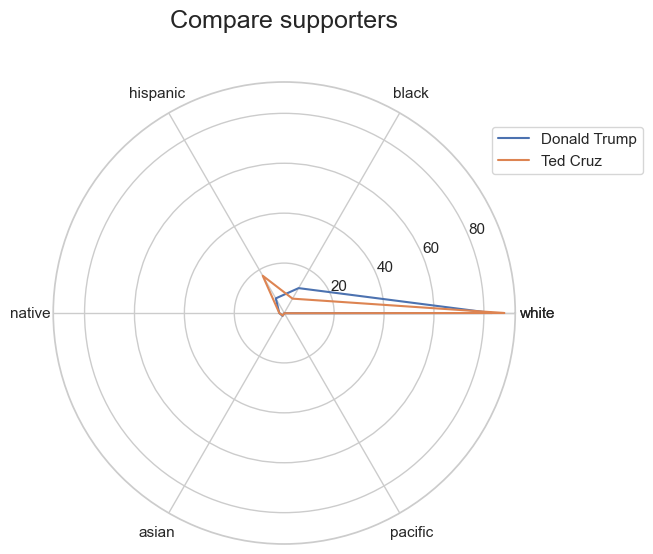

In [447]:
race = ['winner', 'white', 'black', 'hispanic', 'native', 'asian', 'pacific', 'white']
trump = rdf_grouped[race].iloc[1].tolist()
cruz = rdf_grouped[race].iloc[4].tolist()
spider_plot(trump, cruz, race)

We will get rid of the white voters to see the image more clearly

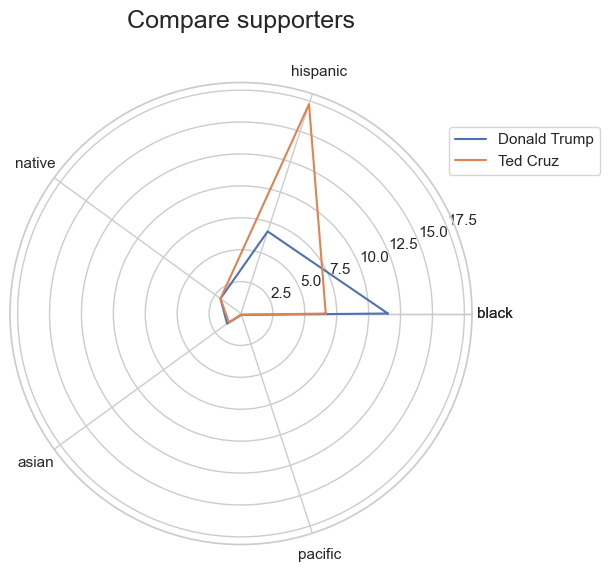

In [448]:
race = ['winner', 'black', 'hispanic', 'native', 'asian', 'pacific', 'black']
trump = rdf_grouped[race].iloc[1].tolist()
cruz = rdf_grouped[race].iloc[4].tolist()

spider_plot(trump, cruz, race)

As we can see Donald Trump is very unpopular among hispanic republican voters, which were almost three times more likely to pick Cruz. These people may be the easiest to sway away from voting republican, if Trump would be the republican candidate

Next we will comapare other features apart from race

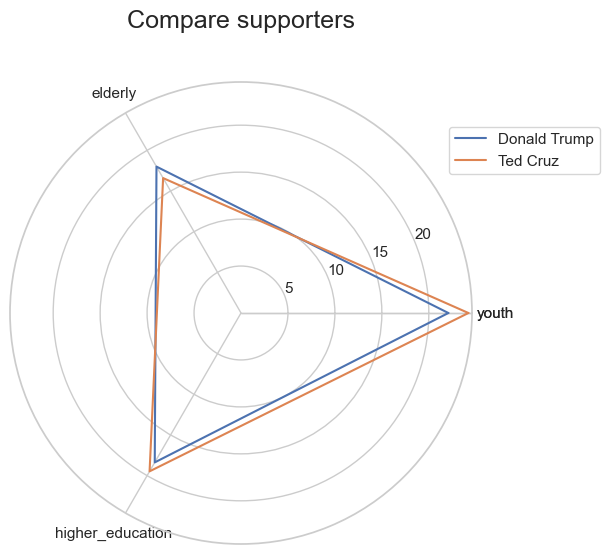

In [419]:
other = ['winner', 'youth', 'elderly', 'higher_education', 'youth']
trump = rdf_grouped[other].iloc[1].tolist()
cruz = rdf_grouped[other].iloc[4].tolist()

spider_plot(trump, cruz, other)

As we can see Trump voters are slightly older and less educated then Cruz voters.

Next, we will look at the democrat primaries data. The two main democrat candidates were Hillary Clinton and Bernie Sanders. We will see how these two stack up against each other.

In [366]:
democrat_votes = primary.query('party == "Democrat"')
grouped_votes = democrat_votes.groupby(['state_abbreviation', 'county', 'fips'])

# Calculate winner, approval, and votes
winner_series = grouped_votes.apply(find_winner)
max_fraction_votes = grouped_votes['fraction_votes'].max()
max_votes = grouped_votes['votes'].max()

# Create the final dataframe
d_votes = pd.DataFrame({
    'winner': winner_series,
    'approval': max_fraction_votes,
    'votes': max_votes
}).reset_index()

d_votes['fips'] = pd.to_numeric(d_votes['fips'], errors='coerce')
d_votes['fips'] = d_votes['fips'].astype(int)


### We change the column names and filter the demographics dataframe
features = ['AGE295214', 'AGE775214', 'SEX255214',
       'RHI725214', 'RHI125214', 'RHI225214', 'RHI325214', 'RHI425214',
       'RHI525214',  'EDU635213', 'EDU685213', 'INC110213', 'POP060210']

renamed_features = ['youth', 'elderly', 'women',
                    'hispanic', 'white', 'black', 'native', 'asian', 
                    'pacific', 'highschool', 'higher_education', 'income', 'density']

filtered_demographics = pd.DataFrame()
filtered_demographics[['fips', 'area_name', 'state_abbreviation'] + renamed_features] = demographics[['fips', 'area_name', 'state_abbreviation'] + features]

filtered_demographics = filtered_demographics.copy()
filtered_demographics['fips'] = filtered_demographics['fips'].astype(int)
ddf = d_votes.merge(filtered_demographics, on=['fips', 'state_abbreviation'])

ddf[renamed_features] = ddf[renamed_features].astype(float)
ddf_grouped = ddf.groupby(['winner'])[renamed_features].mean()
winner_counts = ddf['winner'].value_counts().reset_index()
winner_counts.columns = ['winner', 'occurrences']
print(winner_counts)
ddf_grouped = ddf_grouped.merge(winner_counts, on='winner')

ddf_grouped

            winner  occurrences
0  Hillary Clinton         1640
1   Bernie Sanders         1158


,winner,youth,elderly,women,hispanic,white,black,native,asian,pacific,highschool,higher_education,income,density,occurrences
0,Bernie Sanders,22.232556,17.817012,49.686269,6.722280,91.176857,2.409931,2.938342,1.201123,0.130052,86.766149,20.334024,46089.627807,110.104491,1158
1,Hillary Clinton,22.771646,17.335976,50.163476,11.283415,80.001037,15.524878,1.230732,1.482256,0.091707,82.002561,18.605488,44511.909756,375.765793,1640


The competition between democrat candidates was much more fierce than between republicans, with Clinton barely winning against Sanders. We will now compare their voters by race.

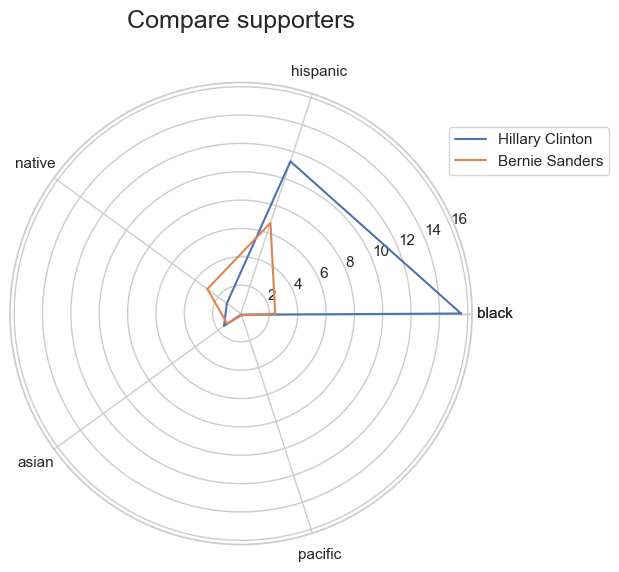

In [420]:
clinton = ddf_grouped[race].iloc[1].tolist()
sanders = ddf_grouped[race].iloc[0].tolist()
spider_plot(clinton, sanders, race)


As we can see the race profile of a Clinton voter is much more diverse then that of a Sanders voter.

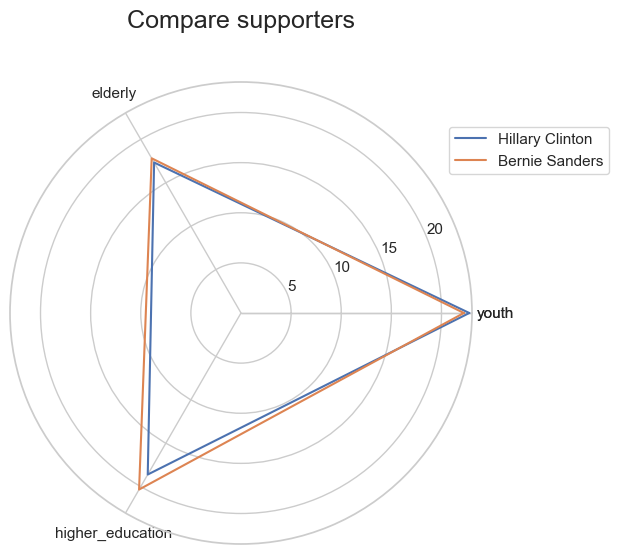

In [422]:
clinton = ddf_grouped[other].iloc[1].tolist()
sanders = ddf_grouped[other].iloc[0].tolist()
spider_plot(clinton, sanders, other)

What's more, Clinton voters tend to be slighty younger and slightly less educated.

Finally, we will compare Trump and Clinton voters with each other.

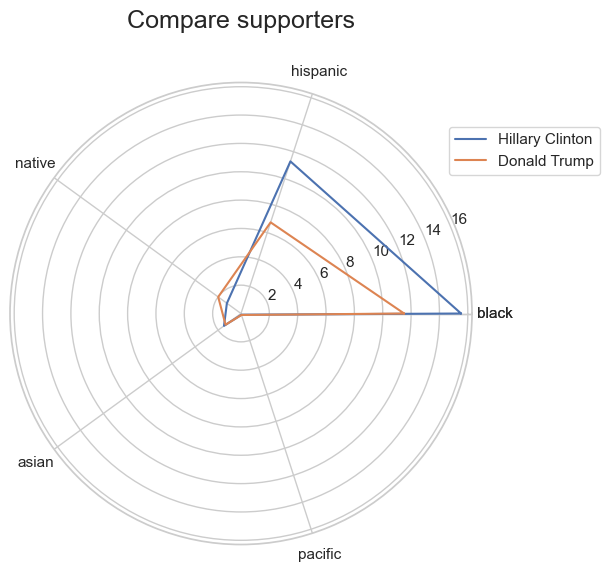

In [423]:
clinton = ddf_grouped[race].iloc[1].tolist()
trump = rdf_grouped[race].iloc[1].tolist()
spider_plot(clinton, trump, race)

As we can see, Clinton voters are much more racially diverse. Hispanic voters are almost twice as likely to vote Clinton than to vote Trump.

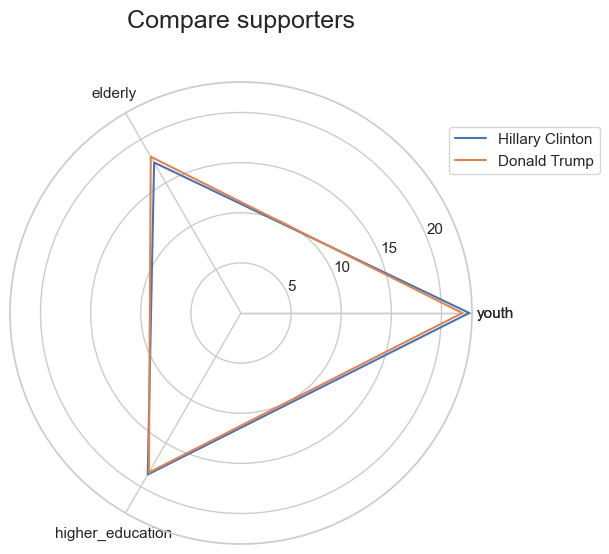

In [424]:
clinton = ddf_grouped[other].iloc[1].tolist()
trump = rdf_grouped[other].iloc[1].tolist()
spider_plot(clinton, trump, other)

Clinton's voters seem to be younger than Trump's. Their education level is on average almost identical.

### Where should we focus?

So far, our analysis suggests that our advantage lies in the more racially diverse parts of the US. We also established in which states the 2016 presidential election race was the tightest. We will now focus on these states and try to pinpoint where exactly we should focus during the campaign the most.

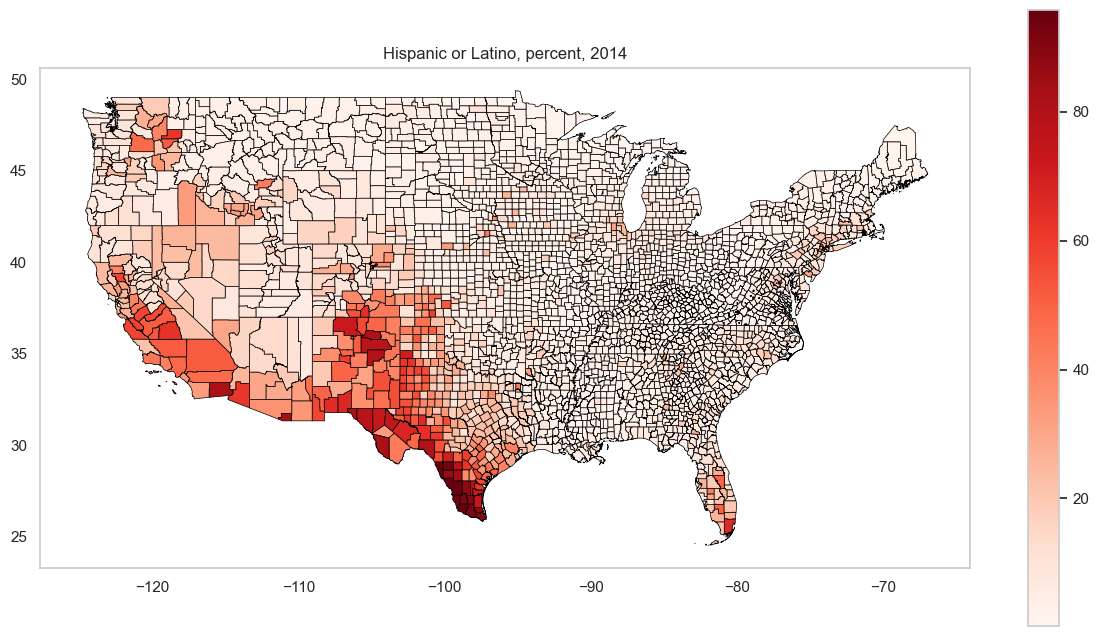

In [449]:
county_shape = gpd.read_file('kaggle_data/county_shapefiles/cb_2014_us_county_500k.shp')
county_facts = pd.read_csv('kaggle_data/county_facts.csv')

county_shape['FIPS'] = county_shape['STATEFP'] + county_shape['COUNTYFP']
county_shape['FIPS'] = county_shape['FIPS'].astype(int)

other_columns = [col for col in county_shape.columns if col != 'FIPS']
new_order = ['FIPS'] + other_columns
county_shape = county_shape[new_order]
county_shape = county_shape.sort_values(by='FIPS')

full_df = county_shape.merge(county_facts, left_on='FIPS', right_on='fips', how='inner')
df = full_df.copy()
df = df[~df['STATEFP'].isin(['15', '02'])]

fig, ax = plt.subplots(figsize=(15,8))
ax = df.plot(ax=ax, cmap='Reds', edgecolor='black', column='RHI725214', linewidth=0.5, legend=True)
plt.title('Hispanic or Latino, percent, 2014')
plt.grid(False)


In [ ]:
def hispanic_density(fips):
    df = full_df.copy()
    df = df[df['STATEFP'].isin([fips])]
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    df.plot(ax=ax[0], cmap='Reds', edgecolor='black', column='RHI725214', linewidth=0.5, legend=True)
    ax[0].set_title('Hispanic or Latino, percent, 2014')
    ax[0].grid(False)

    df.plot(ax=ax[1], cmap='Reds', edgecolor='black', column='PST045214', linewidth=0.5, legend=True)
    ax[1].set_title('Population, 2014')
    ax[1].grid(False)

First we look at Florida

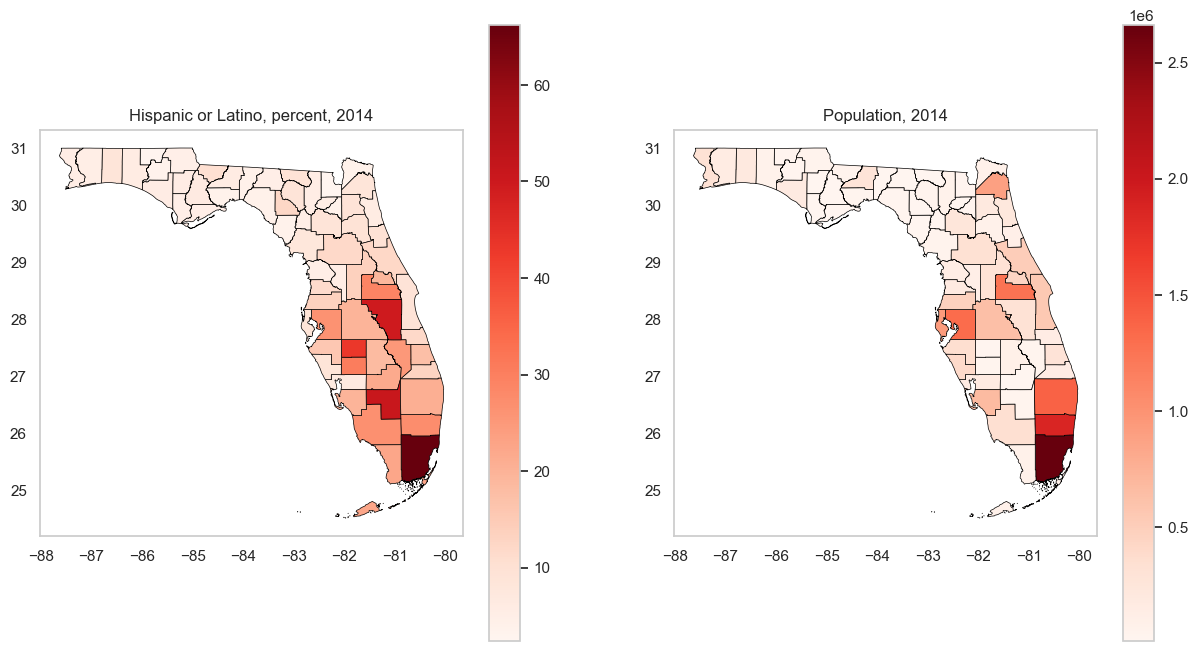

In [430]:
hispanic_density('12')

As we can see Miami-Dade county has the highest hispanic minority (more than 60%) and is also the most populous. We should definitely put there extra attention during our campaign. 

Next we look at Michigan

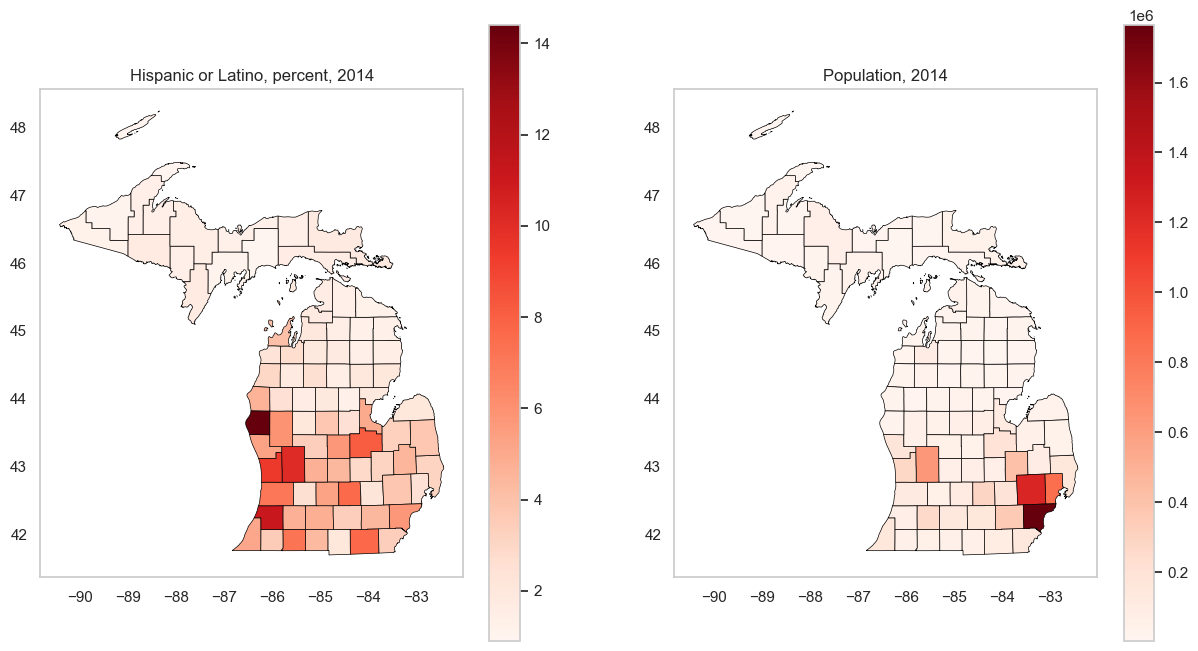

In [425]:
hispanic_density('26')

We can see that most of the hispanic population of Michigan lives in the western part of the state. Places like Oceana and Van Buren counties should be our top priority.
Wayne countie could be consider another hotspot as by far the most people live there.

Next we look at Pennsylvania

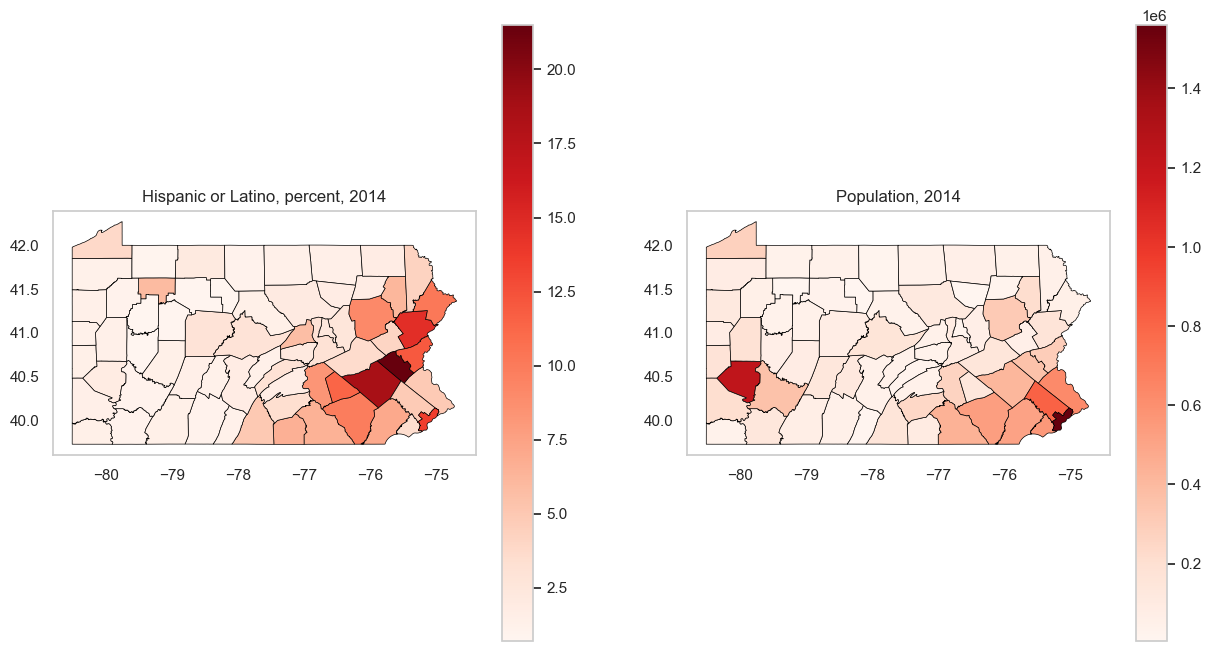

In [427]:
hispanic_density('42')

Most of the hispanic population of Pennsylvania lives on the east of the state in counties like Lehigh and Berks. We should definitely focus on the city of Philadelphia as well as it has both high population and hispanic minority.

Lastly, we look at Wisconsin.

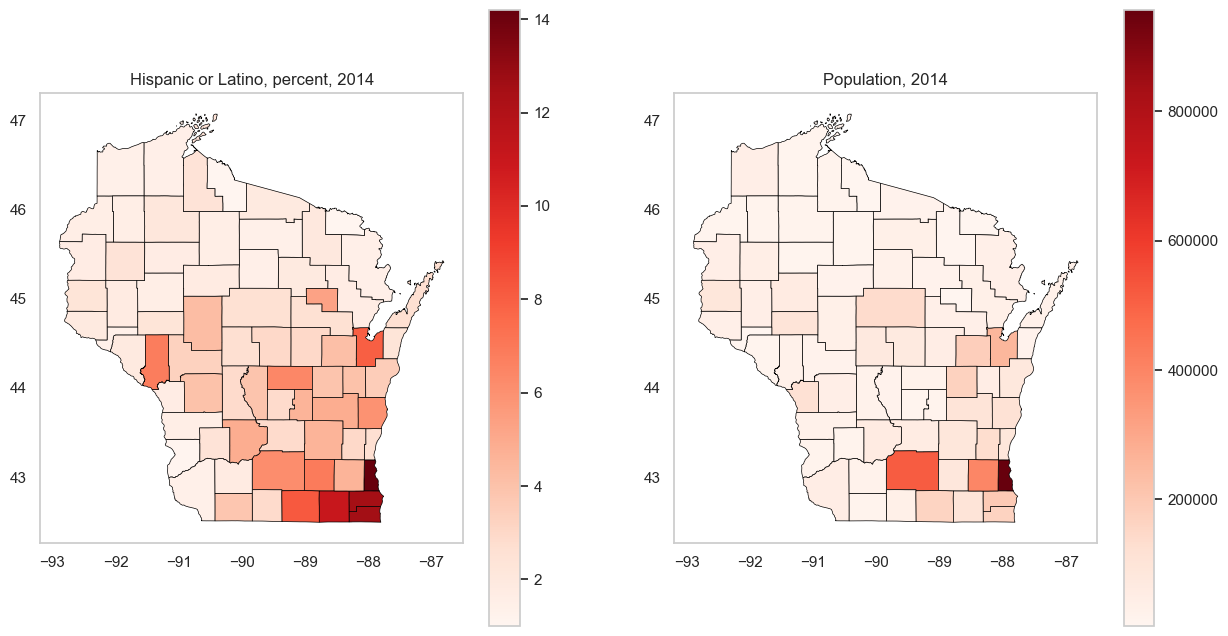

In [428]:
hispanic_density('55')

Most of the hispanic population lives in the south. Most importantly we should focus on Milwaukee county with its high population and high hispanic minority.

### Summary

We looked at the 2016 election results and established that the 4 states that could be the easiest to win back from Trump in 2020:

- Florida
- Michigan
- Pennsylvania
- Winsconsin

We than profiled both Clinton and Trump supporters and established that there is a big difference in their race profiles with hispanic people being especially discontent with Trump.
Lastly we tried to pinpoint in which areas of the swing-states that we intend to win, hispanic population is the highest - this is where we should put most effort during our campaign.
If we could beat Trump in 4 states in the 2020 election (and hold the rest) the overall result would be Trump - 229, Clinton - 302 giving us a decisive win.


#### What actually happened?

Although Trump did run for reelection, Clinton didn't. In the end the Democrats did win the 2020, managing to flip 3 of the 4 states that we listed above (all except Florida).
This would already be enough to grant them the win (although by quiet a small margin), however they also managed to win Arizona and Georgia from Trump making their lead much more decisive. In our analysis we listed Arizona as one of the closest states (won by Trump by a 3,5% margin in 2016). We didn't however expect to be able to win Georgia, which Trump secured in 2016 with more than a 5% lead.